In [1]:
# load the needed extension for the %%R cell magic
%load_ext rpy2.ipython

In [2]:
%load_ext autoreload
%autoreload 2
%load_ext rpy2.ipython
%matplotlib inline

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [3]:
import os
os.chdir('..')  # navigate to the root


In [4]:
from normal_transformers.util.util_data import pickle_load_from_file

In [5]:
from rpy2 import robjects
from rpy2.robjects import Formula, Environment
from rpy2.robjects.vectors import IntVector, FloatVector
from rpy2.robjects.lib import grid
from rpy2.robjects.packages import importr, data
from rpy2.rinterface_lib.embedded import RRuntimeError
import warnings

# The R 'print' function
rprint = robjects.globalenv.find("print")
stats = importr('stats')
grdevices = importr('grDevices')
base = importr('base')
datasets = importr('datasets')

grid.activate()

# plotting
import pandas as pd
import rpy2
import csv

from rpy2.robjects.lib import grdevices
from rpy2.robjects.vectors import IntVector, FloatVector
from IPython.display import Image, display

from rpy2.robjects import pandas2ri
pandas2ri.activate()

import rpy2.robjects as robjects
from rpy2.robjects.lib import grdevices
from rpy2.robjects.vectors import IntVector, FloatVector
from IPython.display import Image, display

import rpy2.robjects.packages as packages
import rpy2.robjects.lib.ggplot2 as ggplot2
import rpy2.robjects as ro

from rpy2.robjects.packages import STAP
with open('examples/theme_publication_tartunlp.R', 'r') as f:
    string = f.read()
pub_theme = STAP(string, "pub_theme")

/home/maksym/.conda/envs/norm/lib/python3.8/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '


In [6]:
# r_utils.install_packages("cowplot")
from pandas.api.types import CategoricalDtype

cowplot = ro.packages.importr('cowplot')

In [7]:
graphics = ro.packages.importr('graphics')
r_utils = ro.packages.importr('utils')
# r_utils.install_packages("ggthemes")
ggthemes = ro.packages.importr('ggthemes')

In [8]:
ggpubr = ro.packages.importr('ggpubr')

Golbals

In [9]:
savedir = "assets/multidomain/"

# Per-layer Clustering Purity

In [10]:
from collections import defaultdict
import numpy as np
from sklearn.cluster import KMeans
import scipy.stats as ss

from normal_transformers.util.util_data import pickle_load_from_file

In [11]:
def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

In [12]:
def cluster_purity_confmatrix(confusion_matrix):
    r = []
    for row_num in confusion_matrix:
        r.append(conf_matrix[row_num].max())
    return sum(r) / confusion_matrix.sum().sum()
    

In [13]:
def prepare_reps(hiddens_dict):
    all_reps_prepared = defaultdict(lambda: list())
    all_labels = defaultdict(lambda: list())
    
    for dn, reps_all_layers in hiddens_dict.items():
        for layer_num, reps_layer in enumerate(reps_all_layers):
            all_reps_prepared[layer_num].extend(reps_layer)
            all_labels[layer_num].extend([dn] * len(reps_layer))
    
    for k, v in all_reps_prepared.items():
        all_reps_prepared[k] = np.array(v)
    
    for k, v in all_labels.items():
        all_labels[k] = np.array(v)
    
    return all_reps_prepared, all_labels

In [14]:
domain_names = ['Europarl', 'OpenSubtitles', 'EMEA', 'JRC-Acquis']

# DE-EN

## BERTs

mono

In [15]:
bdir = "experiments/multidomain/four-domains-de_en/bert-base-german-cased/sentence_embeddings"

hiddens = {}
for dn in domain_names:
    fp = f"{bdir}/sentemb-mean-{dn}.pkl"
    hiddens[dn] = pickle_load_from_file(fp)
    
    

Loading from experiments/multidomain/four-domains-de_en/bert-base-german-cased/sentence_embeddings/sentemb-mean-Europarl.pkl
Loaded
Loading from experiments/multidomain/four-domains-de_en/bert-base-german-cased/sentence_embeddings/sentemb-mean-OpenSubtitles.pkl
Loaded
Loading from experiments/multidomain/four-domains-de_en/bert-base-german-cased/sentence_embeddings/sentemb-mean-EMEA.pkl
Loaded
Loading from experiments/multidomain/four-domains-de_en/bert-base-german-cased/sentence_embeddings/sentemb-mean-JRC-Acquis.pkl
Loaded


In [16]:
%%time

DOMAIN_NAMES = ["Europarl", "OpenSubtitles", "JRC-Acquis", "EMEA"]
NUM_LAYERS = 13


corr_ks = []

hiddens_reps, hiddens_labels = prepare_reps(hiddens)


for l in range(NUM_LAYERS):

    indices = np.arange(hiddens_reps[l].shape[0])
    np.random.shuffle(indices)

    hiddens_shuff = hiddens_reps[l][indices]
    labels_shuff = hiddens_labels[l][indices]

    kmeans = KMeans(n_clusters=4, random_state=0, n_init=10).fit(hiddens_shuff)

    conf_matrix = pd.crosstab(labels_shuff, kmeans.labels_)
    corr_k = cramers_corrected_stat(conf_matrix)
    purity = cluster_purity_confmatrix(conf_matrix)
    corr_ks.append(purity)

    print(f"Layer {l} corr: {corr_k}")
    print("Purity: ", purity)
    #print(conf_matrix)
    


Layer 0 corr: 0.40878749372817097
Purity:  0.4361046317894035
Layer 1 corr: 0.6385474741849089
Purity:  0.6673608797067644
Layer 2 corr: 0.6427378778892875
Purity:  0.6665278240586471
Layer 3 corr: 0.6573385848984644
Purity:  0.672692435854715
Layer 4 corr: 0.6728071620470961
Purity:  0.6831056314561813
Layer 5 corr: 0.6880224126151108
Purity:  0.6913528823725424
Layer 6 corr: 0.6991189274824208
Purity:  0.6966011329556815
Layer 7 corr: 0.7046556001610327
Purity:  0.6998500499833389
Layer 8 corr: 0.6932849167207641
Purity:  0.693352215928024
Layer 9 corr: 0.6743840541508735
Purity:  0.6842719093635455
Layer 10 corr: 0.6701225998888072
Purity:  0.6934355214928357
Layer 11 corr: 0.7129087545866944
Purity:  0.7085971342885705
Layer 12 corr: 0.7259686680256734
Purity:  0.7180106631122959
CPU times: user 7min 28s, sys: 4min 19s, total: 11min 48s
Wall time: 37.8 s


In [17]:
df_corr_ks_bert_de = pd.DataFrame.from_dict({"Layer": range(NUM_LAYERS), "Score": corr_ks})

xlmr

In [18]:
bdir = "experiments/multidomain/four-domains-de_en/xlm-roberta-base/sentence_embeddings"

hiddens = {}
for dn in domain_names:
    fp = f"{bdir}/sentemb-mean-{dn}.pkl"
    hiddens[dn] = pickle_load_from_file(fp)
    
    

Loading from experiments/multidomain/four-domains-de_en/xlm-roberta-base/sentence_embeddings/sentemb-mean-Europarl.pkl
Loaded
Loading from experiments/multidomain/four-domains-de_en/xlm-roberta-base/sentence_embeddings/sentemb-mean-OpenSubtitles.pkl
Loaded
Loading from experiments/multidomain/four-domains-de_en/xlm-roberta-base/sentence_embeddings/sentemb-mean-EMEA.pkl
Loaded
Loading from experiments/multidomain/four-domains-de_en/xlm-roberta-base/sentence_embeddings/sentemb-mean-JRC-Acquis.pkl
Loaded


In [19]:
%%time

DOMAIN_NAMES = ["Europarl", "OpenSubtitles", "JRC-Acquis", "EMEA"]
NUM_LAYERS = 13


corr_ks = []

hiddens_reps, hiddens_labels = prepare_reps(hiddens)


for l in range(NUM_LAYERS):

    indices = np.arange(hiddens_reps[l].shape[0])
    np.random.shuffle(indices)

    hiddens_shuff = hiddens_reps[l][indices]
    labels_shuff = hiddens_labels[l][indices]

    kmeans = KMeans(n_clusters=4, random_state=0, n_init=10).fit(hiddens_shuff)

    conf_matrix = pd.crosstab(labels_shuff, kmeans.labels_)
    corr_k = cramers_corrected_stat(conf_matrix)
    purity = cluster_purity_confmatrix(conf_matrix)
    corr_ks.append(purity)

    print(f"Layer {l} corr: {corr_k}")
    print("Purity: ", purity)
    #print(conf_matrix)
    


Layer 0 corr: 0.4617920827707565
Purity:  0.5214928357214262
Layer 1 corr: 0.40826785196457493
Purity:  0.4748417194268577
Layer 2 corr: 0.4164227799559601
Purity:  0.4750916361212929
Layer 3 corr: 0.40497231812618806
Purity:  0.475674775074975
Layer 4 corr: 0.4199930811689781
Purity:  0.4786737754081973
Layer 5 corr: 0.41708698911166625
Purity:  0.4810063312229257
Layer 6 corr: 0.42965156702482143
Purity:  0.4797567477507497
Layer 7 corr: 0.482332080784484
Purity:  0.49525158280573145
Layer 8 corr: 0.4833419245243601
Purity:  0.4974175274908364
Layer 9 corr: 0.5399926436054097
Purity:  0.5923025658113962
Layer 10 corr: 0.40480365490864806
Purity:  0.4668443852049317
Layer 11 corr: 0.4108360463406002
Purity:  0.4761746084638454
Layer 12 corr: 0.40360557455502616
Purity:  0.4552649116961013
CPU times: user 7min 44s, sys: 3min 52s, total: 11min 37s
Wall time: 37.2 s


In [20]:
df_corr_ks_xlmr = pd.DataFrame.from_dict({"Layer": range(NUM_LAYERS), "Score": corr_ks})

In [21]:
df_corr_ks_bert_de['Model'] = ["German BERT Base" for i in range(len(df_corr_ks_bert_de))]
df_corr_ks_xlmr['Model'] = ["XLM-R Base" for i in range(len(df_corr_ks_xlmr))]
df_corr_ks_bert_all = pd.concat([df_corr_ks_bert_de, df_corr_ks_xlmr], ignore_index=True)

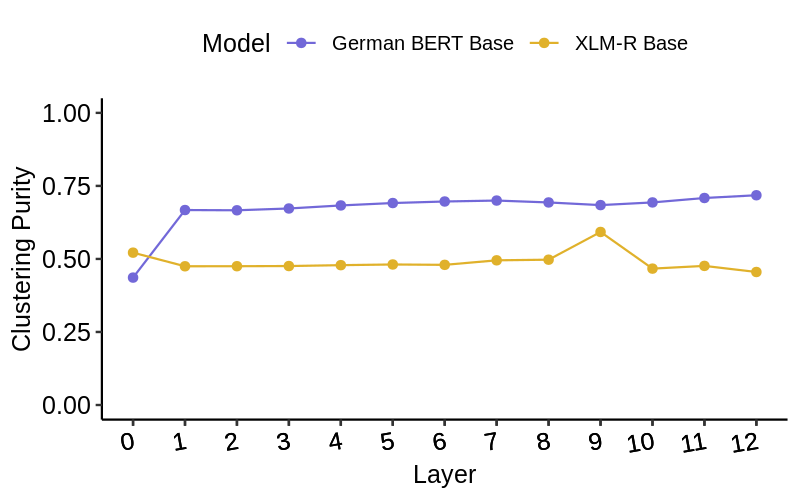

In [22]:

# plot metrics data
with grdevices.render_to_bytesio(grdevices.png, width=800, height=500, res=150) as img:
    # title = f"{model_names_mapping[model_name_or_dir]} -> {sent_rep_type.upper()}"
    plot = ggpubr.ggline(df_corr_ks_bert_all, 
                         x="Layer", 
                         y="Score", 
                         color="Model", 
                         palette=ro.rl("""c("#7268D8", "#E0B12B", "#EF6650", "#4DB6AC", "#3185FF", "#3195FF")"""),
                        ) \
            + ggpubr.theme_pubr(x_text_angle = 10)
    
    pp = plot + ggplot2.ylab("Clustering Purity") + ggplot2.ylim(0,1) \
    + ggplot2.scale_x_continuous(labels = df_corr_ks_bert_all["Layer"], breaks = df_corr_ks_bert_all["Layer"])
    
    pp.plot()
display(Image(data=img.getvalue(), format='png', embed=True))

In [23]:
pp.save("clust_purity-layers-de_en-bert.pdf", width=12, height=6, units="cm", device="pdf", dpi=300, path=savedir)

# EN-ET

BERT

In [24]:
bdir = "experiments/multidomain/four-domains-en_et/bert-base-cased/sentence_embeddings"

hiddens = {}
for dn in domain_names:
    fp = f"{bdir}/sentemb-mean-{dn}.pkl"
    hiddens[dn] = pickle_load_from_file(fp)
    
    

Loading from experiments/multidomain/four-domains-en_et/bert-base-cased/sentence_embeddings/sentemb-mean-Europarl.pkl
Loaded
Loading from experiments/multidomain/four-domains-en_et/bert-base-cased/sentence_embeddings/sentemb-mean-OpenSubtitles.pkl
Loaded
Loading from experiments/multidomain/four-domains-en_et/bert-base-cased/sentence_embeddings/sentemb-mean-EMEA.pkl
Loaded
Loading from experiments/multidomain/four-domains-en_et/bert-base-cased/sentence_embeddings/sentemb-mean-JRC-Acquis.pkl
Loaded


In [25]:
%%time

DOMAIN_NAMES = ["Europarl", "OpenSubtitles", "JRC-Acquis", "EMEA"]
NUM_LAYERS = 13


corr_ks = []

hiddens_reps, hiddens_labels = prepare_reps(hiddens)


for l in range(NUM_LAYERS):

    indices = np.arange(hiddens_reps[l].shape[0])
    np.random.shuffle(indices)

    hiddens_shuff = hiddens_reps[l][indices]
    labels_shuff = hiddens_labels[l][indices]

    kmeans = KMeans(n_clusters=4, random_state=0, n_init=10).fit(hiddens_shuff)

    conf_matrix = pd.crosstab(labels_shuff, kmeans.labels_)
    corr_k = cramers_corrected_stat(conf_matrix)
    purity = cluster_purity_confmatrix(conf_matrix)
    corr_ks.append(purity)

    print(f"Layer {l} corr: {corr_k}")
    print("Purity: ", purity)
    #print(conf_matrix)
    


Layer 0 corr: 0.3931735127807139
Purity:  0.4807564145284905
Layer 1 corr: 0.4484543324311852
Purity:  0.49391869376874376
Layer 2 corr: 0.6103065371645241
Purity:  0.6434521826057981
Layer 3 corr: 0.6127416777755706
Purity:  0.6453682105964679
Layer 4 corr: 0.6112882625049341
Purity:  0.6443685438187271
Layer 5 corr: 0.621251395309221
Purity:  0.649950016661113
Layer 6 corr: 0.5455264071518706
Purity:  0.554481839386871
Layer 7 corr: 0.5299036934812206
Purity:  0.5358213928690436
Layer 8 corr: 0.5531890293618555
Purity:  0.5608963678773742
Layer 9 corr: 0.5618953338463274
Purity:  0.5683938687104299
Layer 10 corr: 0.7078823364271422
Purity:  0.6968510496501167
Layer 11 corr: 0.6632703261425931
Purity:  0.6775241586137954
Layer 12 corr: 0.6549439806059622
Purity:  0.665361546151283
CPU times: user 7min 4s, sys: 4min 15s, total: 11min 20s
Wall time: 36.3 s


In [26]:
df_corr_ks_bert_en = pd.DataFrame.from_dict({"Layer": range(NUM_LAYERS), "Score": corr_ks})

# # with grdevices.render_to_bytesio(grdevices.png, width=800, height=400, res=150) as img:
# #     gp = ggplot2.ggplot(df_corr_ks_bert)
# #     pp = gp \
# #     + ggplot2.aes_string(x='Layer', y='Score') \
# #     + ggplot2.geom_line() \
# #     + ggplot2.scale_x_continuous(labels = df_corr_ks_bert["Layer"], breaks = df_corr_ks_bert["Layer"]) \
# #     + ggplot2.ylab("Clustering Purity") \
# #     + ggplot2.scale_fill_manual(values=["#7268D8", "#E0B12B", "#EF6650", "#4DB6AC", "#3185FF", "#3195FF"]) \
# #     + pub_theme.theme_Publication()
# #     pp.plot()
# # display(Image(data=img.getvalue(), format='png', embed=True))

# # plot metrics data
# with grdevices.render_to_bytesio(grdevices.png, width=700, height=300, res=120) as img:
#     plot = ggpubr.ggline(df_corr_ks_bert_en, 
#                          x="Layer", 
#                          y="Score", 
#                          palette=ro.rl("""c("#7268D8", "#E0B12B", "#EF6650", "#4DB6AC", "#3185FF", "#3195FF")""")) \
#             + ggpubr.theme_pubr(x_text_angle = 10) \
#             + ggplot2.ylab("Clustering Purity") \

#     pp = plot
#     pp.plot()
# display(Image(data=img.getvalue(), format='png', embed=True))

XLM-R

In [27]:
bdir = "experiments/multidomain/four-domains-en_et/xlm-roberta-base/sentence_embeddings"

hiddens = {}
for dn in domain_names:
    fp = f"{bdir}/sentemb-mean-{dn}.pkl"
    hiddens[dn] = pickle_load_from_file(fp)
    
    

Loading from experiments/multidomain/four-domains-en_et/xlm-roberta-base/sentence_embeddings/sentemb-mean-Europarl.pkl
Loaded
Loading from experiments/multidomain/four-domains-en_et/xlm-roberta-base/sentence_embeddings/sentemb-mean-OpenSubtitles.pkl
Loaded
Loading from experiments/multidomain/four-domains-en_et/xlm-roberta-base/sentence_embeddings/sentemb-mean-EMEA.pkl
Loaded
Loading from experiments/multidomain/four-domains-en_et/xlm-roberta-base/sentence_embeddings/sentemb-mean-JRC-Acquis.pkl
Loaded


In [28]:
%%time

DOMAIN_NAMES = ["Europarl", "OpenSubtitles", "JRC-Acquis", "EMEA"]
NUM_LAYERS = 13


corr_ks = []

hiddens_reps, hiddens_labels = prepare_reps(hiddens)


for l in range(NUM_LAYERS):

    indices = np.arange(hiddens_reps[l].shape[0])
    np.random.shuffle(indices)

    hiddens_shuff = hiddens_reps[l][indices]
    labels_shuff = hiddens_labels[l][indices]

    kmeans = KMeans(n_clusters=4, random_state=0, n_init=10).fit(hiddens_shuff)

    conf_matrix = pd.crosstab(labels_shuff, kmeans.labels_)
    corr_k = cramers_corrected_stat(conf_matrix)
    purity = cluster_purity_confmatrix(conf_matrix)
    corr_ks.append(purity)

    print(f"Layer {l} corr: {corr_k}")
    print("Purity: ", purity)
    #print(conf_matrix)
    


Layer 0 corr: 0.37986197234219693
Purity:  0.47600799733422194
Layer 1 corr: 0.3616151776631274
Purity:  0.44560146617794066
Layer 2 corr: 0.37428610338191337
Purity:  0.4595134955014995
Layer 3 corr: 0.3758594046310442
Purity:  0.45626457847384205
Layer 4 corr: 0.39310777319766177
Purity:  0.46951016327890704
Layer 5 corr: 0.38295896134985014
Purity:  0.4696767744085305
Layer 6 corr: 0.3763623272054164
Purity:  0.4617627457514162
Layer 7 corr: 0.48882631777689073
Purity:  0.5407364211929356
Layer 8 corr: 0.4988736432461752
Purity:  0.5442352549150283
Layer 9 corr: 0.47002556980889026
Purity:  0.5327390869710097
Layer 10 corr: 0.3586753940298106
Purity:  0.43960346551149615
Layer 11 corr: 0.359813724434407
Purity:  0.44535154948350547
Layer 12 corr: 0.3609163934108883
Purity:  0.4566811062979007
CPU times: user 7min 50s, sys: 3min 51s, total: 11min 41s
Wall time: 37.4 s


In [29]:
df_corr_ks_bert = pd.DataFrame.from_dict({"Layer": range(NUM_LAYERS), "Score": corr_ks})

# with grdevices.render_to_bytesio(grdevices.png, width=800, height=400, res=150) as img:
#     gp = ggplot2.ggplot(df_corr_ks_bert)
#     pp = gp \
#     + ggplot2.aes_string(x='Layer', y='Score') \
#     + ggplot2.geom_line() \
#     + ggplot2.scale_x_continuous(labels = df_corr_ks_bert["Layer"], breaks = df_corr_ks_bert["Layer"]) \
#     + ggplot2.ylab("Clustering Purity") \
#     + ggplot2.scale_fill_manual(values=["#7268D8", "#E0B12B", "#EF6650", "#4DB6AC", "#3185FF", "#3195FF"]) \
#     + pub_theme.theme_Publication()
#     pp.plot()
# display(Image(data=img.getvalue(), format='png', embed=True))

# # plot metrics data
# with grdevices.render_to_bytesio(grdevices.png, width=700, height=300, res=120) as img:
#     plot = ggpubr.ggline(df_corr_ks_bert, 
#                          x="Layer", 
#                          y="Score", 
#                          palette=ro.rl("""c("#7268D8", "#E0B12B", "#EF6650", "#4DB6AC", "#3185FF", "#3195FF")""")) \
#             + ggpubr.theme_pubr(x_text_angle = 10) \
#             + ggplot2.ylab("Clustering Purity") \

#     pp = plot
#     pp.plot()
# display(Image(data=img.getvalue(), format='png', embed=True))

In [30]:
df_corr_ks_bert_en['Model'] = ["English BERT Base" for i in range(len(df_corr_ks_bert_en))]
df_corr_ks_bert['Model'] = ["XLM-R Base" for i in range(len(df_corr_ks_bert))]
df_corr_ks_bert_all = pd.concat([df_corr_ks_bert, df_corr_ks_bert_en], ignore_index=True)

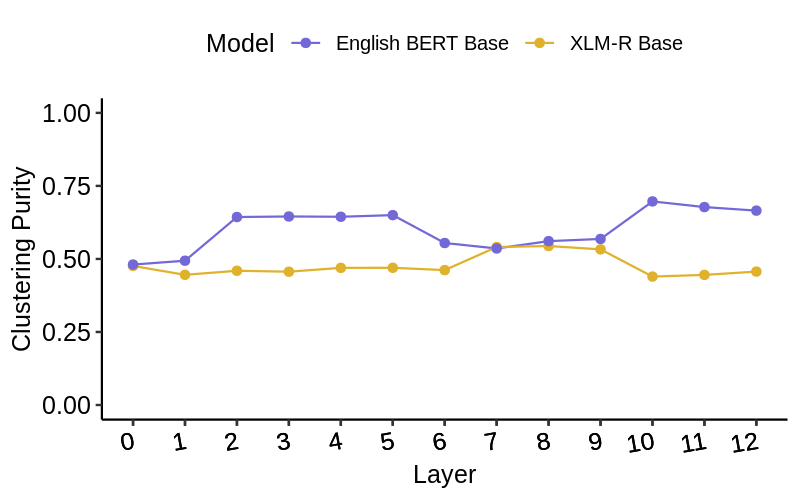

In [31]:

# plot metrics data
with grdevices.render_to_bytesio(grdevices.png, width=800, height=500, res=150) as img:
    # title = f"{model_names_mapping[model_name_or_dir]} -> {sent_rep_type.upper()}"
    plot = ggpubr.ggline(df_corr_ks_bert_all, 
                         x="Layer", 
                         y="Score", 
                         color="Model", 
                         palette=ro.rl("""c("#7268D8", "#E0B12B", "#EF6650", "#4DB6AC", "#3185FF", "#3195FF")"""),
                        ) \
            + ggpubr.theme_pubr(x_text_angle = 10)
    
    pp = plot + ggplot2.ylab("Clustering Purity") + ggplot2.ylim(0,1) \
    + ggplot2.scale_x_continuous(labels = df_corr_ks_bert_all["Layer"], breaks = df_corr_ks_bert_all["Layer"])
    pp.plot()
display(Image(data=img.getvalue(), format='png', embed=True))

In [32]:
pp.save("clust_purity-layers-en_et-bert.pdf", width=12, height=6, units="cm", device="pdf", dpi=300, path=savedir)

## NMT 

chkp 60

In [33]:
bdir = "experiments/multidomain/four-domains-en_et/nmt-model/sentence_embeddings"

hiddens = {}
for dn in domain_names:
    fp = f"{bdir}/sentemb-mean-{dn}.pkl"
    hiddens[dn] = pickle_load_from_file(fp)
    

Loading from experiments/multidomain/four-domains-en_et/nmt-model/sentence_embeddings/sentemb-mean-Europarl.pkl
Loaded
Loading from experiments/multidomain/four-domains-en_et/nmt-model/sentence_embeddings/sentemb-mean-OpenSubtitles.pkl
Loaded
Loading from experiments/multidomain/four-domains-en_et/nmt-model/sentence_embeddings/sentemb-mean-EMEA.pkl
Loaded
Loading from experiments/multidomain/four-domains-en_et/nmt-model/sentence_embeddings/sentemb-mean-JRC-Acquis.pkl
Loaded


In [34]:
%%time

DOMAIN_NAMES = ["Europarl", "OpenSubtitles", "JRC-Acquis", "EMEA"]
NUM_LAYERS = 13


corr_ks = []

hiddens_reps, hiddens_labels = prepare_reps(hiddens)


for l in range(NUM_LAYERS):

    indices = np.arange(hiddens_reps[l].shape[0])
    np.random.shuffle(indices)

    hiddens_shuff = hiddens_reps[l][indices]
    labels_shuff = hiddens_labels[l][indices]

    kmeans = KMeans(n_clusters=4, random_state=0, n_init=10).fit(hiddens_shuff)

    conf_matrix = pd.crosstab(labels_shuff, kmeans.labels_)
    corr_k = cramers_corrected_stat(conf_matrix)
    purity = cluster_purity_confmatrix(conf_matrix)
    corr_ks.append(purity)

    print(f"Layer {l} corr: {corr_k}")
    print("Purity: ", purity)
    #print(conf_matrix)
    


Layer 0 corr: 0.4734833358991467
Purity:  0.49208597134288573
Layer 1 corr: 0.5991638822969718
Purity:  0.6251249583472176
Layer 2 corr: 0.74365694459788
Purity:  0.7954015328223926
Layer 3 corr: 0.7635079315930332
Purity:  0.80973008997001
Layer 4 corr: 0.7412362508398821
Purity:  0.7964011996001333
Layer 5 corr: 0.6171852125342175
Purity:  0.6144618460513163
Layer 6 corr: 0.7159261834251484
Purity:  0.7724091969343552
Layer 7 corr: 0.24144286224096861
Purity:  0.37320893035654784
Layer 8 corr: 0.3414984437309879
Purity:  0.43218927024325227
Layer 9 corr: 0.34287617680675525
Purity:  0.43577140953015664
Layer 10 corr: 0.3664342944030517
Purity:  0.44401866044651783
Layer 11 corr: 0.3661959915638839
Purity:  0.4374375208263912
Layer 12 corr: 0.44927862903551313
Purity:  0.5079973342219261
CPU times: user 6min 20s, sys: 2min 59s, total: 9min 19s
Wall time: 30.4 s


In [35]:
df_corr_ks_nmt_60 = pd.DataFrame.from_dict({"Layer": range(NUM_LAYERS), "Score": corr_ks})

# with grdevices.render_to_bytesio(grdevices.png, width=800, height=400, res=150) as img:
#     gp = ggplot2.ggplot(df_corr_ks_nmt_60)
#     pp = gp \
#     + ggplot2.aes_string(x='Layer', y='Score') \
#     + ggplot2.geom_line() \
#     + ggplot2.scale_x_continuous(labels = df_corr_ks_bert["Layer"], breaks = df_corr_ks_bert["Layer"]) \
#     + ggplot2.ylab("Clustering Purity") \
#     + pub_theme.theme_Publication()
#     pp.plot()
# display(Image(data=img.getvalue(), format='png', embed=True))

chckp 1

In [36]:
bdir = "experiments/multidomain/four-domains-en_et/nmt-model-chkp1/sentence_embeddings"

hiddens = {}
for dn in domain_names:
    fp = f"{bdir}/sentemb-mean-{dn}.pkl"
    hiddens[dn] = pickle_load_from_file(fp)
    

Loading from experiments/multidomain/four-domains-en_et/nmt-model-chkp1/sentence_embeddings/sentemb-mean-Europarl.pkl
Loaded
Loading from experiments/multidomain/four-domains-en_et/nmt-model-chkp1/sentence_embeddings/sentemb-mean-OpenSubtitles.pkl
Loaded
Loading from experiments/multidomain/four-domains-en_et/nmt-model-chkp1/sentence_embeddings/sentemb-mean-EMEA.pkl
Loaded
Loading from experiments/multidomain/four-domains-en_et/nmt-model-chkp1/sentence_embeddings/sentemb-mean-JRC-Acquis.pkl
Loaded


In [37]:
%%time

DOMAIN_NAMES = ["Europarl", "OpenSubtitles", "JRC-Acquis", "EMEA"]
NUM_LAYERS = 13


corr_ks = []

hiddens_reps, hiddens_labels = prepare_reps(hiddens)


for l in range(NUM_LAYERS):

    indices = np.arange(hiddens_reps[l].shape[0])
    np.random.shuffle(indices)

    hiddens_shuff = hiddens_reps[l][indices]
    labels_shuff = hiddens_labels[l][indices]

    kmeans = KMeans(n_clusters=4, random_state=0, n_init=10).fit(hiddens_shuff)

    conf_matrix = pd.crosstab(labels_shuff, kmeans.labels_)
    corr_k = cramers_corrected_stat(conf_matrix)
    purity = cluster_purity_confmatrix(conf_matrix)
    corr_ks.append(purity)

    print(f"Layer {l} corr: {corr_k}")
    print("Purity: ", purity)
    #print(conf_matrix)
    


Layer 0 corr: 0.19825138512945278
Purity:  0.34638453848717093
Layer 1 corr: 0.8351560801220292
Purity:  0.8739586804398534
Layer 2 corr: 0.857482255852152
Purity:  0.8906197934021993
Layer 3 corr: 0.8581249018663526
Purity:  0.8905364878373876
Layer 4 corr: 0.8671573361944497
Purity:  0.8978673775408197
Layer 5 corr: 0.868889279394641
Purity:  0.899616794401866
Layer 6 corr: 0.8815797165777419
Purity:  0.9100299900033322
Layer 7 corr: 0.201892671839616
Purity:  0.3520493168943685
Layer 8 corr: 0.32350776427102307
Purity:  0.4280239920026658
Layer 9 corr: 0.3181605437816778
Purity:  0.42819060313228924
Layer 10 corr: 0.35207516432813507
Purity:  0.4501832722425858
Layer 11 corr: 0.3815896031932453
Purity:  0.4730089970009997
Layer 12 corr: 0.6314905765153661
Purity:  0.6338720426524492
CPU times: user 6min 18s, sys: 2min 57s, total: 9min 16s
Wall time: 30 s


In [38]:
df_corr_ks_nmt_1 = pd.DataFrame.from_dict({"Layer": range(NUM_LAYERS), "Score": corr_ks})

# with grdevices.render_to_bytesio(grdevices.png, width=800, height=400, res=150) as img:
#     gp = ggplot2.ggplot(df_corr_ks_nmt_1)
#     pp = gp \
#     + ggplot2.aes_string(x='Layer', y='Score') \
#     + ggplot2.geom_line() \
#     + ggplot2.scale_x_continuous(labels = df_corr_ks_bert["Layer"], breaks = df_corr_ks_bert["Layer"]) \
#     + ggplot2.ylab("Clustering Purity") \
#     + pub_theme.theme_Publication()
#     pp.plot()
# display(Image(data=img.getvalue(), format='png', embed=True))

In [39]:
df_corr_ks_nmt_60['Model'] = ["NMT Checkpoint 60" for i in range(len(df_corr_ks_nmt_60))]
df_corr_ks_nmt_1['Model'] = ["NMT Checkpoint 1" for i in range(len(df_corr_ks_nmt_1))]
df_corr_ks_nmt = pd.concat([df_corr_ks_nmt_60, df_corr_ks_nmt_1], ignore_index=True)

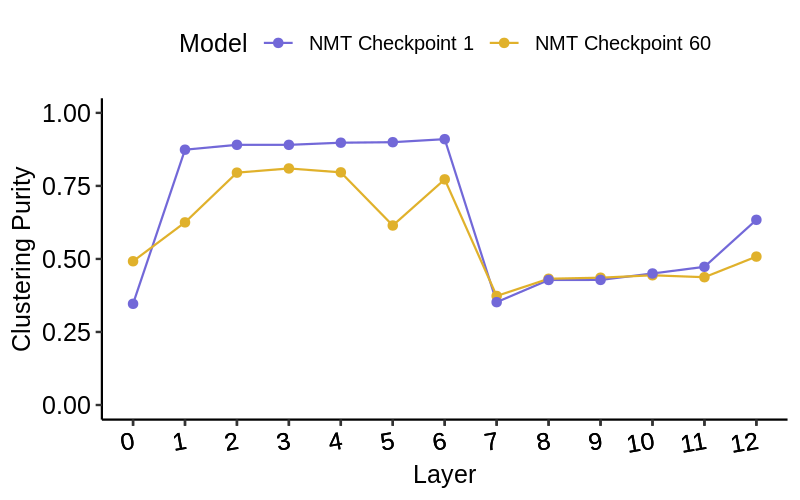

In [40]:

# plot metrics data
with grdevices.render_to_bytesio(grdevices.png, width=800, height=500, res=150) as img:
    # title = f"{model_names_mapping[model_name_or_dir]} -> {sent_rep_type.upper()}"
    plot = ggpubr.ggline(df_corr_ks_nmt, 
                         x="Layer", 
                         y="Score", 
                         color="Model",
                         numeric_x_axis=False,
                         palette=ro.rl("""c("#7268D8", "#E0B12B", "#EF6650", "#4DB6AC", "#3185FF", "#3195FF")"""),
                        ) \
            + ggpubr.theme_pubr(x_text_angle = 10)
    
    pp = plot + ggplot2.ylab("Clustering Purity") + ggplot2.ylim(0,1) \
    + ggplot2.scale_x_continuous(labels = df_corr_ks_nmt["Layer"], breaks = df_corr_ks_nmt["Layer"]) 
    
    pp.plot()
display(Image(data=img.getvalue(), format='png', embed=True))

In [41]:
pp.save("clust_purity-layers-en_et-nmt.pdf", width=12, height=6, units="cm", device="pdf", dpi=300, path=savedir)

* At checkpoint 1 models learns to spearate clusters exceptionally!
* Then, at checkpoint 60, it seems to forget it....
* Maybe I should take something like average perlayer purity (say for encoder)
* and measure it for checkpoints 1, 10, 30, 60, 101

In [42]:
# # r_utils.install_packages("cowplot")
# cowplot = ro.packages.importr('cowplot')

# Confusion Tables & Clustering Purity

In [31]:
import itertools
domain_names = ["Europarl", "OpenSubtitles", "EMEA", "JRC-Acquis"]
clust_names = ['0', '1', '2', '3']

clus_corp_pairs = list(itertools.product(domain_names, clust_names))

In [77]:
def cluster_purity(df):
    r = []
    for cn in clust_names:
        r.append(df[df.cluster_label == cn].max()['count'])
    return round((sum(r) / df['count'].sum()) * 100, 2)

In [78]:
def get_domain(fn, domain_names):
    for d in domain_names:
        if d in fn:
            return d

In [79]:
def compose_labels_pairs_dfs(bp):
    clust_pathes = {}
    clust_pathes["nmt-sent"] = f"{bp}/nmt-clusters-sent"
    clust_pathes["nmt-doc"] = f"{bp}/nmt-clusters-doc"
    clust_pathes["bert-sent"] = f"{bp}/bert-clusters-sent"
    clust_pathes["bert-doc"] = f"{bp}/bert-clusters-doc"


    clust_fnames = {}
    for k, v in clust_pathes.items():
        clust_fnames[k] = fnames = [f for f in next(os.walk(v))[2] if split in f]

    #
    labels_pairs = {}
    for k, v in clust_fnames.items():
        clust_labels = []
        corpus_labels = []
        labels_pairs[k] = []

        for fn in v:
            d = get_domain(fn, domain_names)        

            full_fn = f"{clust_pathes[k]}/{fn}"
            with open(full_fn, "r") as f:
                curr_clust_labels = [l.strip() for l in f.readlines()]
                curr_corpus_labels = [d for i in range(len(curr_clust_labels))]
            clust_labels.extend(curr_clust_labels)
            corpus_labels.extend(curr_corpus_labels)

        labels_pairs[k] = (corpus_labels, clust_labels)

    #
    print("Total counts")
    labels_pairs_dfs = {}
    for k, v in labels_pairs.items():
        print(k, len(v[0]))
        df = pd.DataFrame(
            {'corpus_label': v[0],
             'cluster_label': v[1],
            }).groupby(['corpus_label','cluster_label']).size().reset_index().rename(columns={0:'count'})
        #df['Type'] = [str(k) for i in r
        labels_pairs_dfs[k] = df
        
        
    # Fill NAs
    for k, df in labels_pairs_dfs.items():
        for p in clus_corp_pairs:
            dl, cl = p[0], p[1]
            missing = len(df[(df.corpus_label == dl) & (df.cluster_label == cl)]) == 0

            if missing:
                labels_pairs_dfs[k] = labels_pairs_dfs[k].append({'corpus_label':dl, 'cluster_label':cl, 'count':0}, ignore_index=True)

    return labels_pairs_dfs

## EN-ET

SPLIT: train

Total counts
nmt-sent 1911602
nmt-doc 1911602
bert-sent 1911602
bert-doc 1911602

Clustering purity train:
nmt-sent: 67.21
nmt-doc: 99.61
bert-sent: 53.47
bert-doc: 85.77


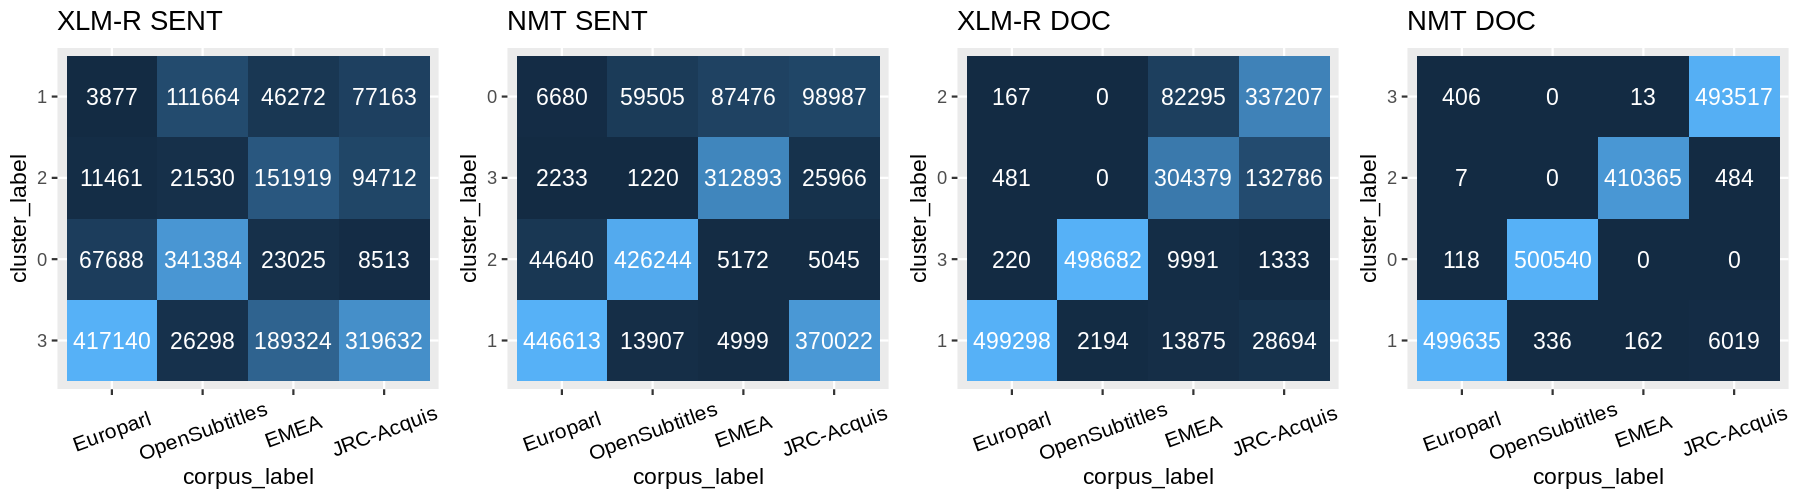

SPLIT: dev-cl

Total counts
nmt-sent 13113
nmt-doc 13113
bert-sent 13113
bert-doc 13113

Clustering purity dev-cl:
nmt-sent: 72.56
nmt-doc: 100.0
bert-sent: 52.9
bert-doc: 72.89


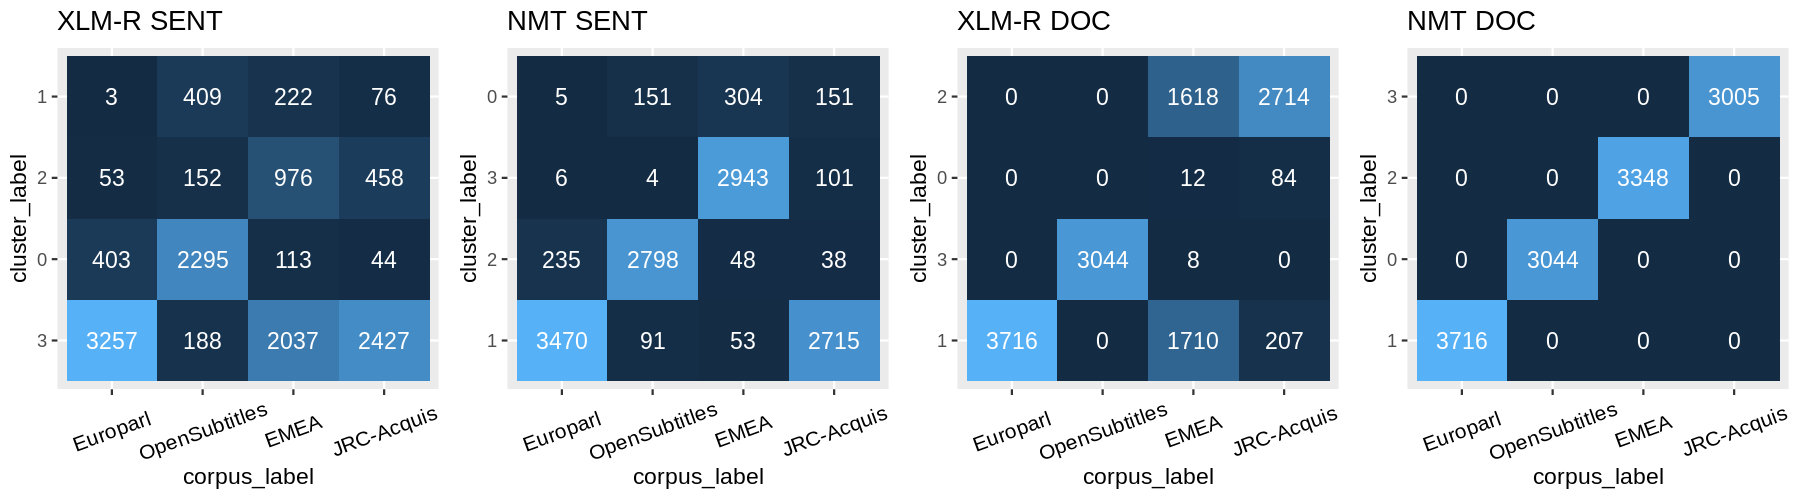

SPLIT: test

Total counts
nmt-sent 12697
nmt-doc 12697
bert-sent 12697
bert-doc 12697

Clustering purity test:
nmt-sent: 70.7
nmt-doc: 99.1
bert-sent: 50.07
bert-doc: 70.14


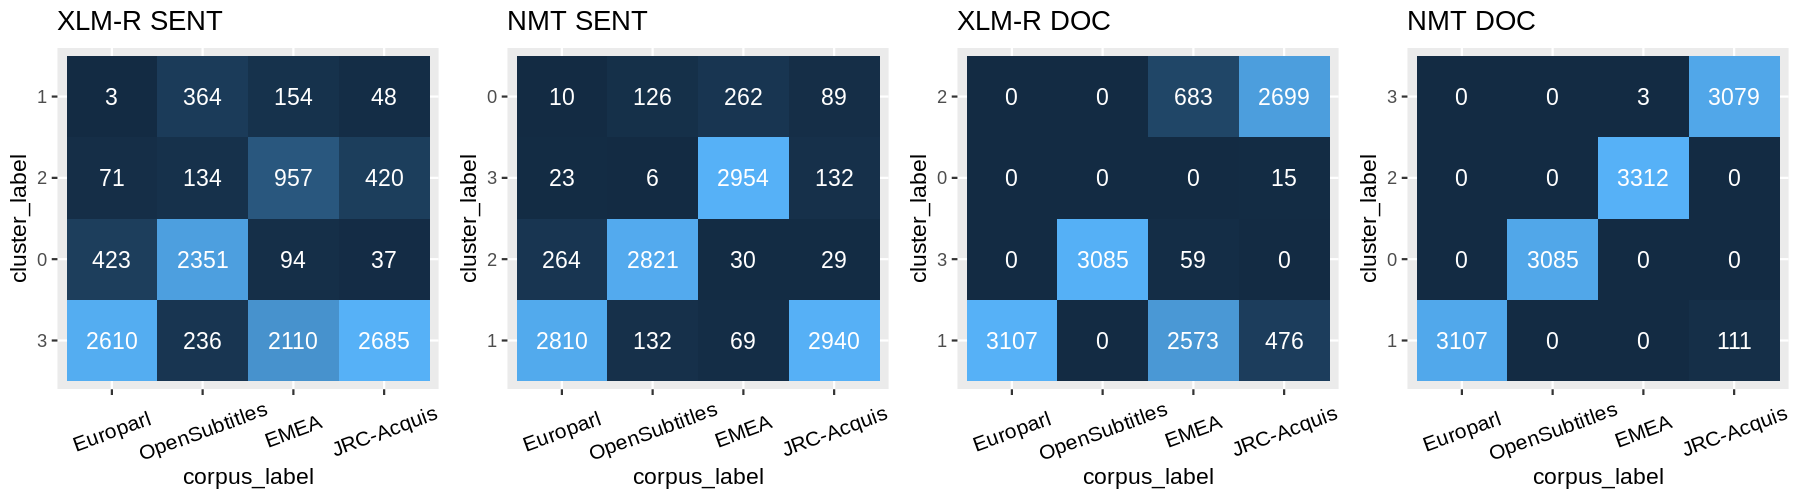

In [80]:
lpair = "en-et"

for split in ["train", "dev-cl", "test"]:
    print(f"SPLIT: {split}\n")

    bp = "/home/maksym/normal-transformers/experiments/multidomain/automatic_domains/clusters-multidomain/clusters_en-et"
    labels_pairs_dfs = compose_labels_pairs_dfs(bp)

    print(f"\nClustering purity {split}:")
    for k, df in labels_pairs_dfs.items():
        cp = cluster_purity(df)
        print(f"{k}: {cp}")

    # Plot
    key = 'nmt-sent'
    title = "NMT SENT"

    cat_clust_labels = CategoricalDtype(categories=['1', '2', '3', '0'], ordered=False)
    cat_corpus_labels = CategoricalDtype(categories=['Europarl', 'OpenSubtitles', 'EMEA', 'JRC-Acquis'], ordered=False)

    labels_pairs_dfs[key]['cluster_label'] = labels_pairs_dfs[key]['cluster_label'].astype(cat_clust_labels)
    labels_pairs_dfs[key]['corpus_label'] = labels_pairs_dfs[key]['corpus_label'].astype(cat_corpus_labels)
    
    # heatmap
    #title = "Encoder: NMT  |  Level: sentence"#f"Interlingua at {all_interlingua_layerids} layers"
    gp = ggplot2.ggplot(labels_pairs_dfs[key])
    heatmap1 = gp \
    + ggplot2.aes_string(x='corpus_label', y='cluster_label', fill="count") \
    + ggplot2.ggtitle(title) \
    + ggplot2.geom_tile() \
    + ggplot2.geom_text(ggplot2.aes_string(label='count'), color='white') \
    + ggplot2.theme(legend_position = "none") +  ggplot2.theme(axis_text_x = ggplot2.element_text(angle = 20))



    key = 'nmt-doc'
    title = "NMT DOC"

    cat_clust_labels = CategoricalDtype(categories=['1', '0', '2', '3'], ordered=False)
    cat_corpus_labels = CategoricalDtype(categories=['Europarl', 'OpenSubtitles', 'EMEA', 'JRC-Acquis'], ordered=False)

    labels_pairs_dfs[key]['cluster_label'] = labels_pairs_dfs[key]['cluster_label'].astype(cat_clust_labels)
    labels_pairs_dfs[key]['corpus_label'] = labels_pairs_dfs[key]['corpus_label'].astype(cat_corpus_labels)

    # heatmap
    #title = "Encoder: NMT  |  Level: sentence"#f"Interlingua at {all_interlingua_layerids} layers"
    gp = ggplot2.ggplot(labels_pairs_dfs[key])
    heatmap2 = gp \
    + ggplot2.aes_string(x='corpus_label', y='cluster_label', fill="count") \
    + ggplot2.ggtitle(title) \
    + ggplot2.geom_tile() \
    + ggplot2.geom_text(ggplot2.aes_string(label='count'), color='white') \
    + ggplot2.theme(legend_position = "none") +  ggplot2.theme(axis_text_x = ggplot2.element_text(angle = 20))


    key = 'bert-sent'
    title = "XLM-R SENT"

    cat_clust_labels = CategoricalDtype(categories=['3', '0', '2', '1'], ordered=False)
    cat_corpus_labels = CategoricalDtype(categories=['Europarl', 'OpenSubtitles', 'EMEA', 'JRC-Acquis'], ordered=False)

    labels_pairs_dfs[key]['cluster_label'] = labels_pairs_dfs[key]['cluster_label'].astype(cat_clust_labels)
    labels_pairs_dfs[key]['corpus_label'] = labels_pairs_dfs[key]['corpus_label'].astype(cat_corpus_labels)

    # heatmap
    #title = "Encoder: NMT  |  Level: sentence"#f"Interlingua at {all_interlingua_layerids} layers"
    gp = ggplot2.ggplot(labels_pairs_dfs[key])
    heatmap3 = gp \
    + ggplot2.aes_string(x='corpus_label', y='cluster_label', fill="count") \
    + ggplot2.ggtitle(title) \
    + ggplot2.geom_tile() \
    + ggplot2.geom_text(ggplot2.aes_string(label='count'), color='white') \
    + ggplot2.theme(legend_position = "none") +  ggplot2.theme(axis_text_x = ggplot2.element_text(angle = 20))


    key = 'bert-doc'
    title = "XLM-R DOC"

    cat_clust_labels = CategoricalDtype(categories=['1', '3', '0', '2'], ordered=False)
    cat_corpus_labels = CategoricalDtype(categories=['Europarl', 'OpenSubtitles', 'EMEA', 'JRC-Acquis'], ordered=False)

    labels_pairs_dfs[key]['cluster_label'] = labels_pairs_dfs[key]['cluster_label'].astype(cat_clust_labels)
    labels_pairs_dfs[key]['corpus_label'] = labels_pairs_dfs[key]['corpus_label'].astype(cat_corpus_labels)

    # heatmap
    #title = "Encoder: NMT  |  Level: sentence"#f"Interlingua at {all_interlingua_layerids} layers"
    gp = ggplot2.ggplot(labels_pairs_dfs[key])
    heatmap4 = gp \
    + ggplot2.aes_string(x='corpus_label', y='cluster_label', fill="count") \
    + ggplot2.ggtitle(title) \
    + ggplot2.geom_tile() \
    + ggplot2.geom_text(ggplot2.aes_string(label='count'), color='white') \
    + ggplot2.theme(legend_position = "none") +  ggplot2.theme(axis_text_x = ggplot2.element_text(angle = 20)) \

    with grdevices.render_to_bytesio(grdevices.png, width=1800, height=500, res=150) as img:
        pp = cowplot.plot_grid(heatmap3, heatmap1, heatmap4, heatmap2, rows=1)
        pp.plot() 
    display(Image(data=img.getvalue(), format='png', embed=True))
    
    pp.save(f"conf_table-{lpair}-{split}.pdf", width=29.7, height=8.25, units="cm", device="pdf", dpi=300, path=savedir)
    

## DE-EN

SPLIT: train

Total counts
nmt-sent 2002484
nmt-doc 2002484
bert-sent 2002484
bert-doc 2002484

Clustering purity train:
nmt-sent: 66.32
nmt-doc: 99.21
bert-sent: 44.04
bert-doc: 97.64


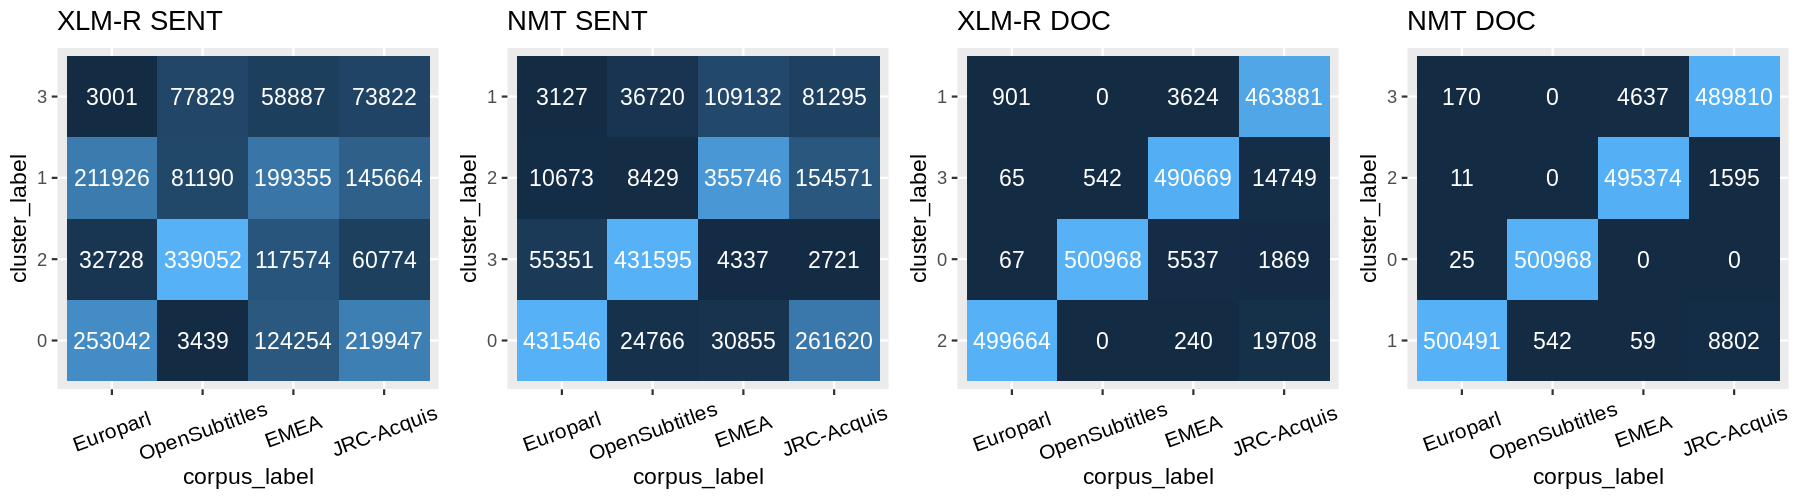

SPLIT: dev-cl

Total counts
nmt-sent 14384
nmt-doc 14384
bert-sent 14384
bert-doc 14384

Clustering purity dev-cl:
nmt-sent: 70.02
nmt-doc: 97.58
bert-sent: 49.2
bert-doc: 91.74


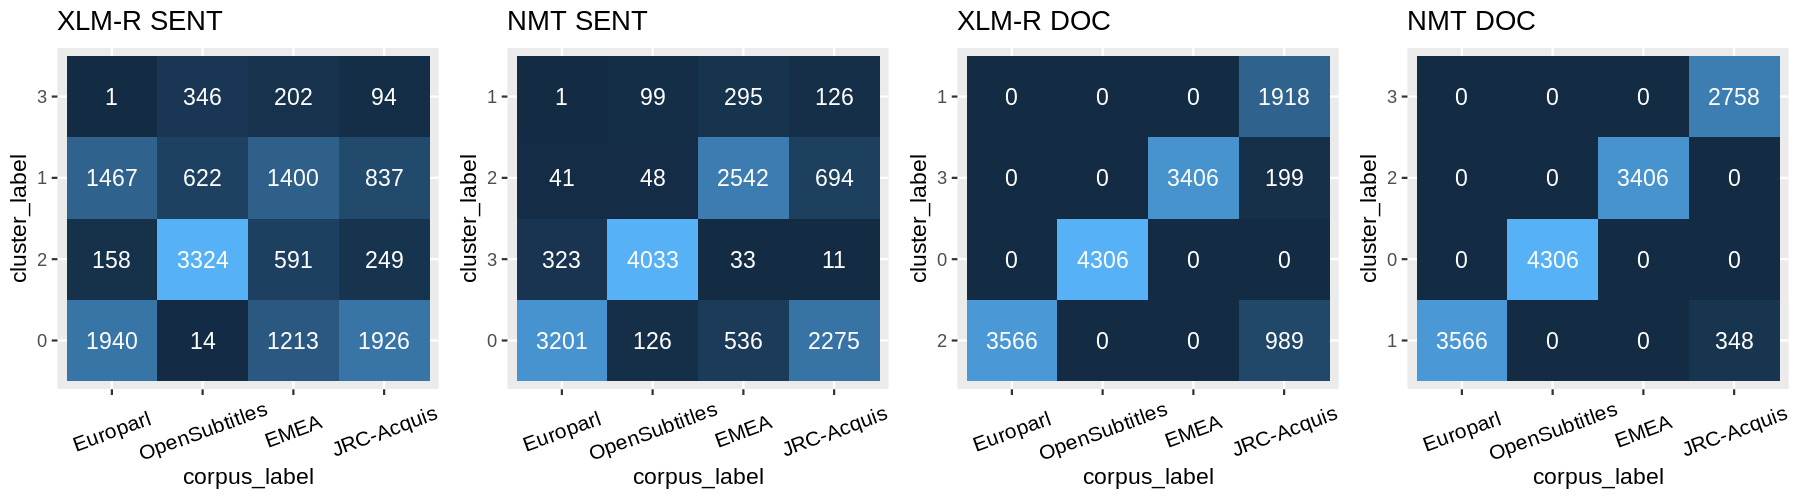

SPLIT: test

Total counts
nmt-sent 15244
nmt-doc 15244
bert-sent 15244
bert-doc 15244

Clustering purity test:
nmt-sent: 72.28
nmt-doc: 99.78
bert-sent: 48.6
bert-doc: 95.23


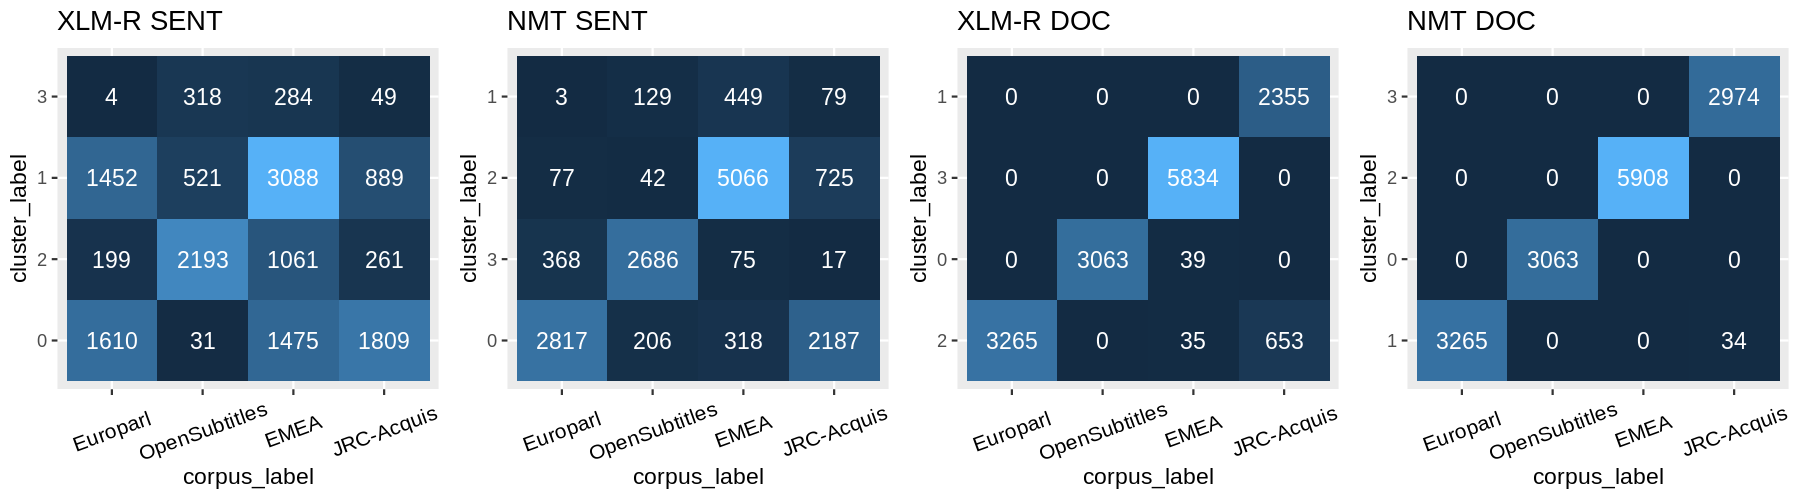

In [81]:
lpair = "de-en"

for split in ["train", "dev-cl", "test"]:
    print(f"SPLIT: {split}\n")

    bp = "/home/maksym/normal-transformers/experiments/multidomain/automatic_domains/clusters-multidomain/clusters_de-en"
    labels_pairs_dfs = compose_labels_pairs_dfs(bp)

    print(f"\nClustering purity {split}:")
    for k, df in labels_pairs_dfs.items():
        cp = cluster_purity(df)
        print(f"{k}: {cp}")

    # Plot
    key = 'nmt-sent'
    title = "NMT SENT"

    cat_clust_labels = CategoricalDtype(categories=['0', '3', '2', '1'], ordered=False)
    cat_corpus_labels = CategoricalDtype(categories=['Europarl', 'OpenSubtitles', 'EMEA', 'JRC-Acquis'], ordered=False)

    labels_pairs_dfs[key]['cluster_label'] = labels_pairs_dfs[key]['cluster_label'].astype(cat_clust_labels)
    labels_pairs_dfs[key]['corpus_label'] = labels_pairs_dfs[key]['corpus_label'].astype(cat_corpus_labels)

    # heatmap
    #title = "Encoder: NMT  |  Level: sentence"#f"Interlingua at {all_interlingua_layerids} layers"
    gp = ggplot2.ggplot(labels_pairs_dfs[key])
    heatmap1 = gp \
    + ggplot2.aes_string(x='corpus_label', y='cluster_label', fill="count") \
    + ggplot2.ggtitle(title) \
    + ggplot2.geom_tile() \
    + ggplot2.geom_text(ggplot2.aes_string(label='count'), color='white') \
    + ggplot2.theme(legend_position = "none") +  ggplot2.theme(axis_text_x = ggplot2.element_text(angle = 20))



    key = 'nmt-doc'
    title = "NMT DOC"

    cat_clust_labels = CategoricalDtype(categories=['1', '0', '2', '3'], ordered=False)
    cat_corpus_labels = CategoricalDtype(categories=['Europarl', 'OpenSubtitles', 'EMEA', 'JRC-Acquis'], ordered=False)

    labels_pairs_dfs[key]['cluster_label'] = labels_pairs_dfs[key]['cluster_label'].astype(cat_clust_labels)
    labels_pairs_dfs[key]['corpus_label'] = labels_pairs_dfs[key]['corpus_label'].astype(cat_corpus_labels)

    # heatmap
    #title = "Encoder: NMT  |  Level: sentence"#f"Interlingua at {all_interlingua_layerids} layers"
    gp = ggplot2.ggplot(labels_pairs_dfs[key])
    heatmap2 = gp \
    + ggplot2.aes_string(x='corpus_label', y='cluster_label', fill="count") \
    + ggplot2.ggtitle(title) \
    + ggplot2.geom_tile() \
    + ggplot2.geom_text(ggplot2.aes_string(label='count'), color='white') \
    + ggplot2.theme(legend_position = "none") +  ggplot2.theme(axis_text_x = ggplot2.element_text(angle = 20))


    key = 'bert-sent'
    title = "XLM-R SENT"

    
    cat_clust_labels = CategoricalDtype(categories=['0', '2', '1', '3'], ordered=False)
    cat_corpus_labels = CategoricalDtype(categories=['Europarl', 'OpenSubtitles', 'EMEA', 'JRC-Acquis'], ordered=False)

    labels_pairs_dfs[key]['cluster_label'] = labels_pairs_dfs[key]['cluster_label'].astype(cat_clust_labels)
    labels_pairs_dfs[key]['corpus_label'] = labels_pairs_dfs[key]['corpus_label'].astype(cat_corpus_labels)

    # heatmap
    #title = "Encoder: NMT  |  Level: sentence"#f"Interlingua at {all_interlingua_layerids} layers"
    gp = ggplot2.ggplot(labels_pairs_dfs[key])
    heatmap3 = gp \
    + ggplot2.aes_string(x='corpus_label', y='cluster_label', fill="count") \
    + ggplot2.ggtitle(title) \
    + ggplot2.geom_tile() \
    + ggplot2.geom_text(ggplot2.aes_string(label='count'), color='white') \
    + ggplot2.theme(legend_position = "none") +  ggplot2.theme(axis_text_x = ggplot2.element_text(angle = 20))


    key = 'bert-doc'
    title = "XLM-R DOC"

    cat_clust_labels = CategoricalDtype(categories=['2', '0', '3', '1'], ordered=False)
    cat_corpus_labels = CategoricalDtype(categories=['Europarl', 'OpenSubtitles', 'EMEA', 'JRC-Acquis'], ordered=False)

    labels_pairs_dfs[key]['cluster_label'] = labels_pairs_dfs[key]['cluster_label'].astype(cat_clust_labels)
    labels_pairs_dfs[key]['corpus_label'] = labels_pairs_dfs[key]['corpus_label'].astype(cat_corpus_labels)

    # heatmap
    #title = "Encoder: NMT  |  Level: sentence"#f"Interlingua at {all_interlingua_layerids} layers"

    gp = ggplot2.ggplot(labels_pairs_dfs[key])
    heatmap4 = gp \
    + ggplot2.aes_string(x='corpus_label', y='cluster_label', fill="count") \
    + ggplot2.ggtitle(title) \
    + ggplot2.geom_tile() \
    + ggplot2.geom_text(ggplot2.aes_string(label='count'), color='white') \
    + ggplot2.theme(legend_position = "none") +  ggplot2.theme(axis_text_x = ggplot2.element_text(angle = 20))





    with grdevices.render_to_bytesio(grdevices.png, width=1800, height=500, res=150) as img:
        pp = cowplot.plot_grid(heatmap3, heatmap1, heatmap4, heatmap2, rows=1) 
        pp.plot() 
    display(Image(data=img.getvalue(), format='png', embed=True))
    
    pp.save(f"conf_table-{lpair}-{split}.pdf", width=29.7, height=8.25, units="cm", device="pdf", dpi=300, path=savedir)


# Stats

In [82]:
# bert doc
# 437646 sents, 8669070 tokens
# 544061 sents, 16185004 tokens
# 419669 sents, 11227990 tokens
# 510226 sents, 5367675 tokens

# bert sent
# 440610 sents, 4887451 tokens
# 238976 sents, 972809 tokens
# 279622 sents, 3074726 tokens
# 952394 sents, 32514753 tokens

# nmt doc
# 500658 sents, 5329120 tokens
# 506152 sents, 15149366 tokens
# 410856 sents, 7617303 tokens
# 493936 sents, 13353950 tokens

# nmt sent
# 252651 sents, 1034957 tokens
# 835541 sents, 27815748 tokens
# 481098 sents, 5238259 tokens
# 342312 sents, 7360775 tokens

# rand
# 478097 sents, 10381779 tokens
# 478346 sents, 10367107 tokens
# 477660 sents, 10360378 tokens
# 477499 sents, 10340475 tokens

In [106]:
bs =  [(440610 , 4887451), 
 (238976 , 972809), 
 (279622 , 3074726), 
 (952394 , 32514753)] 

for p in bs:
    print(round(p[1] / p[0]))

11
4
11
34


In [107]:
bd = [(437646, 8669070), (544061, 16185004), (419669, 11227990), (510226, 5367675)]

for p in bd:
    print(round(p[1] / p[0]))

20
30
27
11


In [108]:
ns = [(252651 , 1034957 ),
(835541 , 27815748),
(481098 , 5238259 ),
(342312 , 7360775 )]

for p in ns:
    print(round(p[1] / p[0]))

4
33
11
22


In [109]:
nd = [(500658 , 5329120),
( 506152 , 15149366),
( 410856 , 7617303), 
( 493936 , 13353950)]

for p in nd:
    print(round(p[1] / p[0]))

11
30
19
27


In [110]:
rand = [(478097, 10381779),
(478346, 10367107),
(477660, 10360378),
(477499, 10340475)]

for p in rand:
    print(round(p[1] / p[0]))

22
22
22
22


In [ ]:
# corpus id DE-EN
# 500070 sents, 9558350 tokens
#  500697 sents, 15637061 tokens
# 500207 sents, 13197439 tokens
# 501510 sents, 5024610 

In [111]:
corpid = [(500070, 9558350 ),
(500697, 15637061),
(500207 , 13197439),
(501510 , 5024610 )]

for p in corpid:
    print(round(p[1] / p[0]))

19
31
26
10


In [114]:
# EN-ET CORPID

corpid = [(410540+410540,   7204084+6805718),
   (500166 + 500166,  14453173 + 12452392),
   (500020 + 500020,  13046636 + 10504164),
   (500876 + 500876,   4834243 + 4205176)]

for p in corpid:
    print(round(p[1] / p[0]))

17
27
24
9


# Misc

In [238]:
bdir = "experiments/multidomain/four-domains-en_et/nmt-model/sentence_embeddings"

hiddens = {}
for dn in domain_names:
    fp = f"{bdir}/sentemb-mean-{dn}.pkl"
    hiddens[dn] = pickle_load_from_file(fp)
    

Loading from experiments/multidomain/four-domains-en_et/nmt-model/sentence_embeddings/sentemb-mean-Europarl.pkl
Loaded
Loading from experiments/multidomain/four-domains-en_et/nmt-model/sentence_embeddings/sentemb-mean-OpenSubtitles.pkl
Loaded
Loading from experiments/multidomain/four-domains-en_et/nmt-model/sentence_embeddings/sentemb-mean-EMEA.pkl
Loaded
Loading from experiments/multidomain/four-domains-en_et/nmt-model/sentence_embeddings/sentemb-mean-JRC-Acquis.pkl
Loaded


In [239]:
%%time

DOMAIN_NAMES = ["Europarl", "OpenSubtitles", "JRC-Acquis", "EMEA"]
NUM_LAYERS = 14


corr_ks = []

hiddens_reps, hiddens_labels = prepare_reps(hiddens)


for l in range(NUM_LAYERS):

    indices = np.arange(hiddens_reps[l].shape[0])
    np.random.shuffle(indices)

    hiddens_shuff = hiddens_reps[l][indices]
    labels_shuff = hiddens_labels[l][indices]

    kmeans = KMeans(n_clusters=4, random_state=0, n_init=20).fit(hiddens_shuff)

    conf_matrix = pd.crosstab(labels_shuff, kmeans.labels_)
    corr_k = cramers_corrected_stat(conf_matrix)
    corr_ks.append(corr_k)

    print(f"Layer {l} corr: {corr_k}")
    print(conf_matrix)

Layer 0 corr: 0.4777677017789821
col_0             0     1     2    3
row_0                               
EMEA              0  2509   689  150
Europarl          6  1813  1553  344
JRC-Acquis        0  1466  1082  457
OpenSubtitles  2019   972    46    7
Layer 1 corr: 0.596244246355513
col_0             0     1    2     3
row_0                               
EMEA           2012   344  918    74
Europarl        118   694   36  2868
JRC-Acquis      308   141  471  2085
OpenSubtitles    82  2616  346     0
Layer 2 corr: 0.7415241035037464
col_0             0     1     2     3
row_0                                
EMEA            758    53    40  2497
Europarl        637   220  2822    37
JRC-Acquis      361  2105   253   286
OpenSubtitles  2957     0    27    60
Layer 3 corr: 0.7611968255131059
col_0             0     1     2     3
row_0                                
EMEA             28    39   722  2559
Europarl       2876   207   603    30
JRC-Acquis      238  2155   389   223
OpenSub

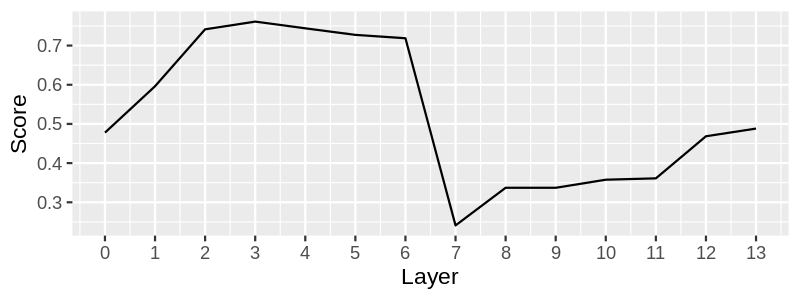

In [241]:
df_corr_ks_nmt = pd.DataFrame.from_dict({"Layer": range(NUM_LAYERS), "Score": corr_ks})

with grdevices.render_to_bytesio(grdevices.png, width=800, height=300, res=150) as img:
    gp = ggplot2.ggplot(df_corr_ks_nmt)
    pp = gp \
    + ggplot2.aes_string(x='Layer', y='Score') \
    + ggplot2.geom_line() \
    + ggplot2.scale_x_continuous(labels = df_corr_ks_nmt["Layer"], breaks = df_corr_ks_nmt["Layer"]) 
    pp.plot()
display(Image(data=img.getvalue(), format='png', embed=True))